# Feature extraction

In [1]:
import polars as pl
ticker = pl.read_csv('ticker.csv')
trades = pl.read_csv('trades.csv')

In [3]:
trades = trades.sort("local_ts")
ticker = ticker.sort("local_ts")

In [3]:

trades = trades.with_columns(
    datetime = (pl.col("local_ts")).cast(pl.Datetime).dt.with_time_unit("ns"),
    volume = trades['price']*trades['amount']
)

In [3]:
import numpy as np

In [4]:
trades = trades.sort("datetime")

trades = trades.with_columns(
    rolling_amount=pl.col("amount").rolling_sum(window_size='2000ms', min_periods =0, by = 'datetime', closed= 'both'),
    rolling_volume=pl.col("volume").rolling_sum(window_size='2000ms', min_periods =0, by = 'datetime', closed= 'both'),
    TFI = (pl.when(pl.col("side") == 'B').then(pl.lit(1)).otherwise(pl.lit(-1)) * pl.col('volume')).rolling_sum(window_size='2000ms', min_periods =0, by = 'datetime', closed= 'both')
)


trades = trades.with_columns(
    rolling_price = (trades['rolling_volume']/trades['rolling_amount'])
)
trades = trades.with_columns(
    log_returns = (np.log(trades['rolling_price']/trades['rolling_price'].shift(1)))
)

trades = trades.with_columns(pl.col("log_returns").fill_null(strategy="zero"))

/home/matvey/.pyenv/versions/3.9.16/envs/ML_project/lib/python3.9/site-packages/polars/series/series.py:1188: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


In [5]:
trades = trades.with_columns(
    rolling_mean=pl.col("log_returns").rolling_mean(window_size='5m', min_periods =0, by = 'datetime', closed= 'both'),
    rolling_var=pl.col("log_returns").rolling_var(window_size='5m', min_periods =0, by = 'datetime', closed= 'both')
    
)

In [6]:
trades = trades.with_columns(
    auto_corr_1 = (((pl.col('log_returns')*pl.col('log_returns').shift(1).fill_null(strategy="zero")).rolling_mean(window_size='5m', min_periods =0, by = 'datetime', closed= 'both') - (pl.col('rolling_mean') * pl.col('rolling_mean').shift(1).fill_null(strategy="zero")))/(pl.col('rolling_var')*pl.col('rolling_var').shift(1).fill_null(strategy="zero"))**(0.5)).fill_nan(0),
    auto_corr_2 = (((pl.col('log_returns')*pl.col('log_returns').shift(2).fill_null(strategy="zero")).rolling_mean(window_size='5m', min_periods =0, by = 'datetime', closed= 'both') - (pl.col('rolling_mean') * pl.col('rolling_mean').shift(2).fill_null(strategy="zero")))/(pl.col('rolling_var')*pl.col('rolling_var').shift(2).fill_null(strategy="zero"))**(0.5)).fill_nan(0),
    auto_corr_3 = (((pl.col('log_returns')*pl.col('log_returns').shift(3).fill_null(strategy="zero")).rolling_mean(window_size='5m', min_periods =0, by = 'datetime', closed= 'both') - (pl.col('rolling_mean') * pl.col('rolling_mean').shift(3).fill_null(strategy="zero")))/(pl.col('rolling_var')*pl.col('rolling_var').shift(3).fill_null(strategy="zero"))**(0.5)).fill_nan(0),
    auto_corr_4 = (((pl.col('log_returns')*pl.col('log_returns').shift(4).fill_null(strategy="zero")).rolling_mean(window_size='5m', min_periods =0, by = 'datetime', closed= 'both') - (pl.col('rolling_mean') * pl.col('rolling_mean').shift(4).fill_null(strategy="zero")))/(pl.col('rolling_var')*pl.col('rolling_var').shift(4).fill_null(strategy="zero"))**(0.5)).fill_nan(0),
    auto_corr_5 = (((pl.col('log_returns')*pl.col('log_returns').shift(5).fill_null(strategy="zero")).rolling_mean(window_size='5m', min_periods =0, by = 'datetime', closed= 'both') - (pl.col('rolling_mean') * pl.col('rolling_mean').shift(5).fill_null(strategy="zero")))/(pl.col('rolling_var')*pl.col('rolling_var').shift(5).fill_null(strategy="zero"))**(0.5)).fill_nan(0),
    realized_volatility = (pl.col('log_returns')**2).rolling_sum(window_size='5m', min_periods =0, by = 'datetime', closed= 'both'),
    BV = (np.pi/2)*(abs(pl.col('log_returns'))*abs(pl.col('log_returns').shift(1).fill_null(strategy="zero"))).rolling_sum(window_size='5m', min_periods =0, by = 'datetime', closed= 'both'),
)

In [7]:
def parzen(x):
    if x>1:
        return 0
    elif x<=1/2:
        return 1-6*x**2+6*x**3
    else:
        return 2*((1-x)**3)


In [8]:
trades = trades.with_columns(
    kernel = pl.col('realized_volatility') + parzen(1/5)*2*pl.col('auto_corr_1')*(pl.col('rolling_var')*pl.col('rolling_var').shift(1).fill_null(strategy="zero"))**(0.5)
        +parzen(2/5)*2*pl.col('auto_corr_2')*(pl.col('rolling_var')*pl.col('rolling_var').shift(2).fill_null(strategy="zero"))**(0.5)
        +parzen(3/5)*2*pl.col('auto_corr_3')*(pl.col('rolling_var')*pl.col('rolling_var').shift(3).fill_null(strategy="zero"))**(0.5)
        +parzen(4/5)*2*pl.col('auto_corr_4')*(pl.col('rolling_var')*pl.col('rolling_var').shift(4).fill_null(strategy="zero"))**(0.5)
        +parzen(5/5)*2*pl.col('auto_corr_5')*(pl.col('rolling_var')*pl.col('rolling_var').shift(5).fill_null(strategy="zero"))**(0.5),
    jump = np.maximum(pl.col('realized_volatility') - pl.col('BV'), 0)
)

In [9]:
ticker = ticker.with_columns(
    mid_price_weight_imb = (pl.col('bid_price')*pl.col('bid_amount') + pl.col('ask_price')*pl.col('ask_amount'))/(pl.col('bid_amount') + pl.col('ask_amount')),
    volume_imbalance = (pl.col('bid_amount') - pl.col('ask_amount'))/(pl.col('bid_amount') + pl.col('ask_amount')),
    spread = pl.col('ask_price') - pl.col('bid_price'),
    normalized_spread = (pl.col('ask_price') - pl.col('bid_price'))/0.1
)

In [10]:
trades = trades.sort("local_ts")
ticker = ticker.sort("local_ts")

In [11]:
all = ticker.join_asof(trades, on="local_ts", strategy="backward")

In [12]:
all = all[['log_returns','auto_corr_1','auto_corr_2','auto_corr_3','auto_corr_4', 'auto_corr_5', 'realized_volatility','kernel','jump', 'mid_price_weight_imb','spread','normalized_spread', 'volume_imbalance', 'TFI']]
X = all.to_numpy()

In [13]:
np.save('final_data.npy', X)

# Modeling

In [1]:
import numpy as np
import polars as pl
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
X = np.load('final_data.npy')
X[np.isnan(X)] = 0
target = pl.read_csv('target1 .csv')
y = target['clf_target1'].to_numpy()


In [10]:
y.shape

(37566023,)

In [2]:
X_train = X[:30000000]
y_train = y[:30000000]

X_val = X[30000000:34000000]
y_val = y[30000000:34000000]

y_test = y[34000000:]
X_test = X[34000000:]

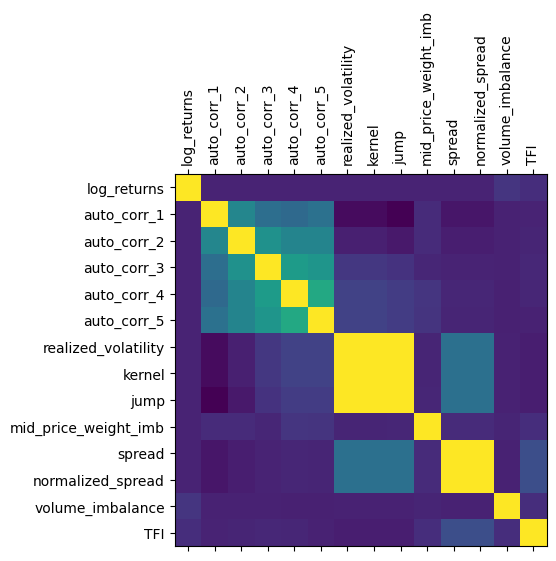

In [3]:
import matplotlib.pyplot as plt


plt.matshow(np.corrcoef(X_train.T))
plt.xticks(np.arange(14), ['log_returns','auto_corr_1','auto_corr_2','auto_corr_3','auto_corr_4', 'auto_corr_5', 'realized_volatility','kernel','jump', 'mid_price_weight_imb','spread','normalized_spread', 'volume_imbalance', 'TFI'], rotation ='vertical')
plt.yticks(np.arange(14), ['log_returns','auto_corr_1','auto_corr_2','auto_corr_3','auto_corr_4', 'auto_corr_5', 'realized_volatility','kernel','jump', 'mid_price_weight_imb','spread','normalized_spread', 'volume_imbalance', 'TFI'], rotation ='horizontal')

plt.show()

In [4]:
from sklearn.model_selection import ParameterGrid
param_grid = {'lr': [0.1, 0.05], 'depth': [5, 10], 'iterations': [50, 100]}
params = ParameterGrid(param_grid)

In [5]:
from catboost import CatBoostClassifier
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

best_model = 0
best_f1 = 0
best_param = 0
for param in tqdm(params):
# Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=param['iterations'],
                            learning_rate=param['lr'],
                            depth=param['depth'],
                            l2_leaf_reg = 3,
                            leaf_estimation_iterations = 10,
                            loss_function='MultiClass',
                            task_type="GPU",
                            verbose=False)
    # Fit model
    model.fit(X_train, y_train)
    f1 = f1_score(y_val, model.predict(X_val), average='weighted')
    if f1>best_f1:
        best_f1 = f1
        best_model = model
        best_param = param
print('Best val f1 weighted:', best_f1)
print('Best params', best_param)

100%|██████████| 8/8 [03:20<00:00, 25.08s/it]

Best val f1 weighted: 0.5432207144623846
Best params {'depth': 10, 'iterations': 100, 'lr': 0.05}


In [6]:
print('Test f1 score weighted:', f1_score(y_test, best_model.predict(X_test), average='weighted'))

Test f1 score weighted: 0.5477229263111387


<Axes: ylabel='Feature'>

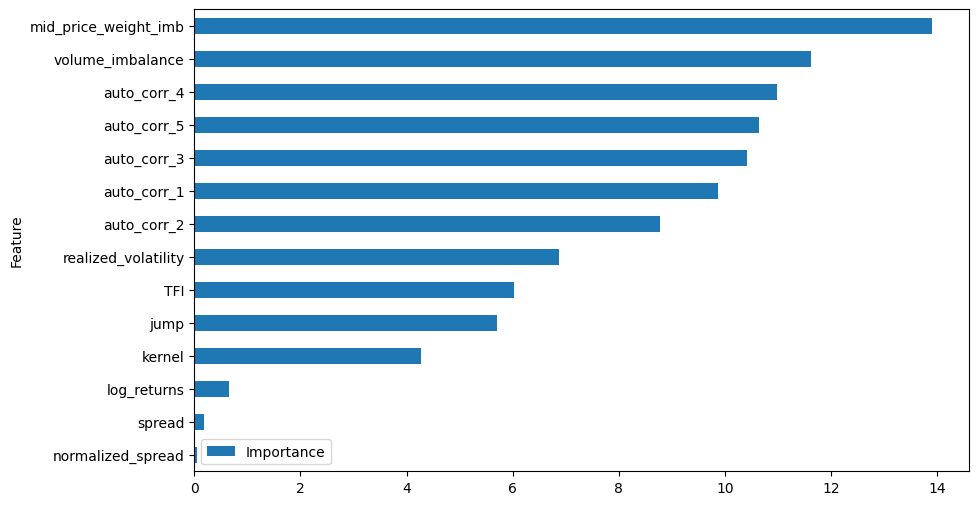

In [7]:
import pandas as pd

coefficients = best_model.feature_importances_

# avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': ['log_returns','auto_corr_1','auto_corr_2','auto_corr_3','auto_corr_4', 'auto_corr_5', 'realized_volatility','kernel','jump', 'mid_price_weight_imb','spread','normalized_spread', 'volume_imbalance', 'TFI'], 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))